In [117]:
import pandas as pd
import ast
import networkx as nx
import numpy as np
from tqdm import tqdm
import math
from scipy.stats import spearmanr


In [69]:
# Function that takes in list of authorIds and outputs the corresponding top fields in the same order 
def author_field(ids, df_author):
    """
    Compute the top field of the given authors 

    Args:
        ids (list): containing the ids of the authors in question
        df_author (pandas df): data frame of type author that contains the given ids 
    
    return: 
        fields (list): list of top fields of the given authors 

    """
    # Get boolean array that indicates where the authors are 
    mask = df_author["id"].isin(ids)
    
    # Get the fields 
    fields = list(df_author["field"][mask]) 
    
    return fields 


In [70]:
def argument_paper_dataframe(df_papers, df_author):
    """
    Takes in a paper data frame, arguments it with a new column and puts the fields of the author in that column.

    Args:
        df_papers (pandas dataframe): paper dataframe (like before)
        df_author (pandas dataframe): author dataframe (like before)

    Returns:
        df_papers (pandas dataframe): the dataframe from before, argumentet with the new column
    """
    df_papers["author_field"] = None 

    for index, row in tqdm(df_papers.iterrows()):
        # Currently authors are stored as a string representation of the list so we make it a list again 
        authors = ast.literal_eval(row["authors"]) 
        # Now we need to turn the authors into a list of integers, because the df_paper dataframe stores them as such
        authors = [eval(id) for id in authors if id is not None]
        #authors = [eval(id) for id in authors]
        # Find the fields of the authors 
        authors_fields = author_field(authors, df_author=df_author)
        df_papers["author_field"][index] = authors_fields
        # print(authors_fields) # debugging 
    # print(df_papers.head()) # debugging 
        
    return df_papers 


In [71]:
# Clean the paper datafram to a social science dataframe
def generate_CCS_papers_1(df_papers, social_science_fields, quantitative_fields, verbose=False):
    
    rows_to_drop = []
    
    # Drop paper if the fields are not not included in social science fields
    for index, row in df_papers.iterrows():
        is_in_SCF = False 
        # Go through the entire list of fields for each paper 
        try: 
            for field in ast.literal_eval(row["field"]):
                if field["category"] in social_science_fields:
                    is_in_SCF = True
        except: 
            is_in_SCF = False 
        
        # if the paper was not in social science fields drop it 
        if not is_in_SCF: 
            rows_to_drop.append(index)
    if verbose: print(f"{len(rows_to_drop)} papers removed because thier fields not in Social Science Fields. ({len(rows_to_drop)/len(df_papers)*100:.0f}%)")
    df_papers.drop(index=rows_to_drop, inplace=True) 
    rows_to_drop = []
    
    # Drop rows that are before 2008
    for index, row in tqdm(df_papers.iterrows()):
        if row["year"] <= 2008: 
            rows_to_drop.append(index)
    if verbose: print(f"{len(rows_to_drop)} papers removed because they were to old. ({len(rows_to_drop)/len(df_papers)*100:.0f}%)")
    df_papers.drop(index=rows_to_drop, inplace=True) 
    rows_to_drop = []
    
        
    # Drop rows that do not contain a DOI
    for index, row in df_papers.iterrows():
        if row["doi"] == None: 
            rows_to_drop.append(index)
        else: 
            try:
                ast.literal_eval(row["doi"])[0]["DOI"]
            except: 
                rows_to_drop.append(index)
    if verbose: print(f"{len(rows_to_drop)} papers removed because they did not have a DOI. ({len(rows_to_drop)/len(df_papers)*100:.0f}%)")
    df_papers.drop(index=rows_to_drop, inplace=True) 
    rows_to_drop = []
    
    # Drop paper if it includes biology
    for index, row in df_papers.iterrows():
        # Go through the entire list of fields for each paper 
        for field in ast.literal_eval(row["field"]):
            if field["category"] == "Biology":
                rows_to_drop.append(index)
    if verbose: print(f"{len(rows_to_drop)} papers removed because biology was in the field. ({len(rows_to_drop)/len(df_papers)*100:.0f}%)")
    df_papers.drop(index=rows_to_drop, inplace=True) 
    rows_to_drop = []
    
    return df_papers


# It is time consuming to add a row in the dataframe, hence it helps that the dataframe is 100 times smaller 
def generate_CCS_papers_2(df_papers, social_science_fields, quantitative_fields, verbose=False):
    
    rows_to_drop = []
    
    # Drop the papers with more than 9 Computational Social Science authors? TODO what does she mean! 
    for index, row in df_papers.iterrows():
        if len(row["author_field"]) > 9: # Count authors, should I check if they are in the author data frame? That's gonna take a while
            rows_to_drop.append(index)
    if verbose: print(f"{len(rows_to_drop)} papers removed because there are more than 9 CSS authors. ({len(rows_to_drop)/len(df_papers)*100:.0f}%)")
    df_papers.drop(index=rows_to_drop, inplace=True) 
    rows_to_drop = []
    
    # Drop paper if the fields are not not included in quantitative data and authors aren't either
    for index, row in df_papers.iterrows():
        is_in_SCF = False 
        # Go through the entire list of fields for each paper 
        for field in ast.literal_eval(row["field"]):
            if field["category"] in quantitative_fields:
                is_in_SCF = True
        
        # Check if the authors are in the quantitative_fields
        for author_field in row["author_field"]: 
            if author_field in quantitative_fields: 
                is_in_SCF = True
       
        # if the paper was not in social science fields drop it 
        if not is_in_SCF: 
            rows_to_drop.append(index)
    if verbose: print(f"{len(rows_to_drop)} papers removed because thier fields and authors are not in Quantitative Fields. ({len(rows_to_drop)/len(df_papers)*100:.0f}%)")
    df_papers.drop(index=rows_to_drop, inplace=True) 
    rows_to_drop = []
    
    return df_papers
    

In [72]:
# Heuristic 
social_science_fields = {"Political Science", "Sociology", "Economics"}
quantitative_fields = {"Mathematics", "Physics", "Computer Science"}

# Load dataframes
df_author = pd.read_csv("df_author.csv")
df_papers = pd.read_csv("df_paper.csv")

# Drop papers, but not based on the authors
n_papers_before = len(df_papers)

print(f"Initially we have {n_papers_before} papers.")
df_papers = generate_CCS_papers_1(df_papers, social_science_fields, quantitative_fields, verbose=True)

# Papers removed so far 
print(f"There are {len(df_papers)} papers left of {n_papers_before} which is {100*len(df_papers)/n_papers_before:.2f}%") 

Initially we have 1078817 papers.
1010697 papers removed because thier fields not in Social Science Fields. (94%)


68120it [00:02, 28072.65it/s]


20011 papers removed because they were to old. (29%)
11330 papers removed because they did not have a DOI. (24%)
98 papers removed because biology was in the field. (0%)
There are 36681 papers left of 1078817 which is 3.40%


In [2]:
# Now the time consuming part 
# Argment paper dataframe 
df_papers = argument_paper_dataframe(df_papers=df_papers, df_author=df_author)

NameError: name 'argument_paper_dataframe' is not defined

In [74]:
# Drop papers based on authors 
df_papers = generate_CCS_papers_2(df_papers, social_science_fields, quantitative_fields, verbose=True)

print(f"There are {len(df_papers)} papers left of {n_papers_before} which is {100*len(df_papers)/n_papers_before:.2f}%") 

165 papers removed because there are more than 9 CSS authors. (0%)
31084 papers removed because thier fields and authors are not in Quantitative Fields. (85%)
There are 5432 papers left of 1078817 which is 0.50%


In [75]:
# Remove duplicates 
n_papers = len(df_papers)
df_papers.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], inplace=True) # weird columns that were somehow created? 
df_papers.drop_duplicates(subset=["id"], inplace=True)
print(f"Removed {n_papers - len(df_papers)} that were duplicates. ({100*(n_papers - len(df_papers)) / n_papers :.2f}%)")
print(f"There are {len(df_papers)} left")

Removed 403 that were duplicates. (92.58%)
There are 5029 left


In [76]:
# Save the agumentet dataframe 
pd.DataFrame.to_csv(df_papers, "df_CSS_paper.csv")

# TODO Check how many unique authors have written these papers. 

In [36]:
# Load dataframe (don't wanna run everything above)
df_CSS_papers = pd.read_csv("df_CSS_paper.csv")
df_authors = pd.read_csv("df_author.csv")

In [37]:
# Print 10 top papers 
df_CSS_papers.sort_values(by=["citationCount"], ascending=False, inplace=True)
for i, paper in df_CSS_papers.head(10).iterrows():
    print(f"'{paper['title']}' has {int(paper['citationCount'])} citations.")

'Linked Data - The Story So Far' has 5527 citations.
'The future of employment: How susceptible are jobs to computerisation?' has 5025 citations.
'CRITICAL QUESTIONS FOR BIG DATA' has 3422 citations.
'Network Analysis in the Social Sciences' has 3363 citations.
'I tweet honestly, I tweet passionately: Twitter users, context collapse, and the imagined audience' has 3042 citations.
'MatchIt: Nonparametric Preprocessing for Parametric Causal Inference' has 2816 citations.
'Fixed Effects Regression Models' has 2739 citations.
'Causal Inference without Balance Checking: Coarsened Exact Matching' has 2428 citations.
'Regret Analysis of Stochastic and Nonstochastic Multi-armed Bandit Problems' has 2355 citations.
'Wikidata: a free collaborative knowledgebase' has 2133 citations.


In [38]:
# Get unique authors 
authors = set() 

for i, paper in df_CSS_papers.iterrows(): 
    paper_authors = set(ast.literal_eval(paper["authors"]))
    authors.update(paper_authors)
    
if None in authors: # If no is in the author list 
    authors.remove(None)

authors = set([int(id) for id in authors]) # convert strings to ints to compare them
total_CSS_authors = set([int(author) for author in df_authors["id"]])

CSS_authors = authors & total_CSS_authors
    
print(f"From the {len(df_CSS_papers)} papers there are {len(authors)} unique authors, but only {len(CSS_authors)} are from our original data frame.")

From the 23441 papers there are 49989 unique authors, but only 10727 are from our original data frame.


In [39]:
# Helper function 
def fix_authors(authors, CSS_authors):
    #Fix string, none type and type errors
    authors = ast.literal_eval(authors)
    authors = [int(id) for id in authors if id != None]
    authors = set(authors) & CSS_authors
    return authors

In [40]:
# Got through all CSS papers and initialize a dictionary with collabaration 
author_dict = {}

for authors in tqdm(df_CSS_papers['authors']):
    authors = fix_authors(authors, CSS_authors=CSS_authors) # Get author in correct shape 

    sorted_authors = sorted(authors) # Sort authors to consistantly index dictionary 
    for i, author in enumerate(sorted_authors):
            for coauthor in sorted_authors[i+1:]:
                    author, coauthor = int(author), int(coauthor)
                    try: 
                        author_dict[author, coauthor] += 1
                    except:
                        author_dict[author, coauthor] = 1

100%|██████████| 23441/23441 [00:00<00:00, 67039.15it/s]


In [41]:
#Creating weighted edges to use in network
weighted_edges = []
for author, coauthor in tqdm(author_dict.keys()):
    weighted_edges.append((author, coauthor, author_dict[author, coauthor]))

CSS_graph = nx.Graph()
CSS_graph.add_nodes_from(CSS_authors)
CSS_graph.add_weighted_edges_from(weighted_edges)

100%|██████████| 15992/15992 [00:00<00:00, 1453136.11it/s]


In [129]:
#Getting node atributes
# First 2 atts
author_atts = dict()

for author in tqdm(list(CSS_authors)):
    author_atts[author] = dict()

    #Getting the name of each author
    names = [df_authors.loc[df_authors['id'] == author, 'name'].values[0]]
    
    aliases = df_authors.loc[df_authors['id'] == author, 'aliases'].values[0]
    
    if type(aliases) == float:
        continue
    
    aliases = ast.literal_eval(aliases)
    names = names + aliases
    longest_name = max(aliases, key=len) #Asume the true name is the longest alias
    author_atts[author]['att1'] = longest_name


    field = df_authors.loc[df_authors['id'] == author, 'field'].values[0]
    author_atts[author]['att2'] = field

100%|██████████| 10727/10727 [00:11<00:00, 954.50it/s] 


In [43]:
#Last three atts

citation_dict = {}
amount_of_css_papers = {}
first_paper_year = {}

# Setup dicts
for author in CSS_authors:
    amount_of_css_papers[author] = 0
    citation_dict[author] = []
    first_paper_year[author] = np.inf # going for the first paper created from the author which much be eariler than inf

# Counting the papers each author as contributed to
for authors in df_CSS_papers['authors']:
    authors = fix_authors(authors, CSS_authors)

    for author in authors:
        amount_of_css_papers[author] += 1



for i, paper in df_CSS_papers.iterrows():

    authors = fix_authors(paper['authors'], CSS_authors)

    for author in authors:
        # Citation count
        citation_dict[author].append(paper['citationCount'])

        #First paper
        if paper['year'] < first_paper_year[author]:
            first_paper_year[author] = paper['year']

In [44]:
# Create attribute
for author in CSS_authors:

    author_atts[author]['att3'] = np.median(citation_dict[author])
    author_atts[author]['att4'] = amount_of_css_papers[author]
    author_atts[author]['att5'] = first_paper_year[author]

In [130]:
# Set node attributes
nx.set_node_attributes(CSS_graph, author_atts)

In [ ]:
# Save network 
nx.write_graphml(CSS_graph, "CSS_graph.graphml")

# Part 4

#### 1:  Why do you think I want you guys to use an undirected graph? Could have we used an directed graph instead?

Undirected graphs are used when a link is mutual, such that one cannot be linked to another without the reverse being true as well. This fits well with these collaborations, as one cannot collaborate with a person without that person collaborating with you as well.
We could have used a directed graph, representing all the mutual links as two directed links, but this would be somewhat redundant.


#### 2: What is the total number of nodes in the network? What is the total number of links? What is the density of the network (that is the total number of links over the maximum number of links)?

In [80]:
print(f"The number of nodes (authors) are {CSS_graph.number_of_nodes()}")
print(f"The number of edges is {CSS_graph.number_of_edges()}")
print(f"The total number of possible edges are {(CSS_graph.number_of_nodes()**2 - CSS_graph.number_of_nodes())/2}")
print(f"And the density is {nx.density(CSS_graph)}")

The number of nodes (authors) are 10727
The number of edges is 15992
The total number of possible edges are 57528901.0
And the density is 0.00027798201811642467


#### 3: What are the average, median, mode, minimum and maximum value of the degree? What are the average, median, mode, minimum and maximum value of the nodes strength? How do you intepret the results?


In [84]:
#calculating key values
print("The average degree is:", np.mean(list(dict(CSS_graph.degree(CSS_authors)).values())))
print("The median is ", np.median(list(dict(CSS_graph.degree(CSS_authors)).values())))
#Getting the mode of the graph
count = {}
for i in dict(CSS_graph.degree(CSS_authors)).values():
    try:
        count[i] += 1
    except:
        count[i] = 1
mode = max(count, key=count.get)
print("The mode of the graph is:", mode)
print("Minimal amount of degrees", min(list(dict(CSS_graph.degree(CSS_authors)).values())))
print("Maximal amount of degrees", max(list(dict(CSS_graph.degree(CSS_authors)).values())))

The average degree is: 2.9816351263167706
The median is  2.0
The mode of the graph is: 0
Minimal amount of degrees 0
Maximal amount of degrees 83


#### 4: List the top 5 authors by degree. What is their total number of citations?

In [144]:
#Sort by the degrees to get those with most
dict_degree = dict(CSS_graph.degree(CSS_authors))
sorted_items = sorted(dict_degree.items(), key=lambda x: x[1], reverse=True)[:5]
top_keys = [k for k, v in sorted_items]

#Get the names from the found ids
dict_names = nx.get_node_attributes(CSS_graph, "att1")
names = [dict_names.get(key, None) for key in top_keys]

print("The names of the authors with the most collabarations are:", names)

The names of the authors with the most collabarations are: ['Ingmar G. Weber', 'David M. J. Lazer', 'Iyad Rahwan', 'Dirk Helbing', 'Meeyoung Cha']


In [151]:
#Their number of citations
citations = []

for id in top_keys:
   citations.append(df_authors.loc[df_authors['id'] == id, 'citationCount'].values[0])

print("Each of their citation counts are:", citations, "and the total is:", sum(citations))


Each of their citation counts are: [9626.0, 21455.0, 9991.0, 47531.0, 14456.0] and the total is: 103059.0


#### 6: Plot the distribution of degrees, using appropriate binning. What do you observe?

#### 7: Plot a scatter plot of the the degree versus the "median number of citations" per ccs paper for all authors. Use logarithmic axes where appropriate. Compute the spearman correlation between the two.

In [152]:
import matplotlib.pyplot as plt

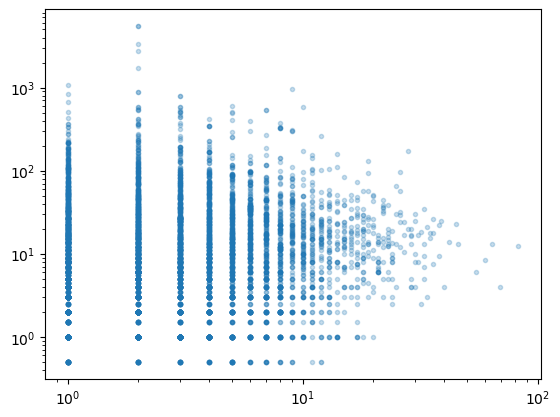

In [173]:
degree_list = list(dict(CSS_graph.degree(CSS_authors)).values())
median_citations = nx.get_node_attributes(CSS_graph, "att3").values()
#print(degree_list)
plt.yscale("log")
plt.xscale("log")
plt.plot(degree_list, median_citations,".",alpha=0.25)

#### 9 : Why do you think I wanted you guys to use the Spearman correlation (instead of the usual Pearson correlation)?


In [185]:
print(spearmanr(degree_list, list(median_citations)))

SpearmanrResult(correlation=0.18965131016869635, pvalue=1.990752965710616e-87)


Spearman correlation does not assume a distribution, whereas pearson assumes, among other things, a normal distribution. As the data is not normally distributed this makes spearman better.
#kig igen hvis afleveres!!!!!!

#### Comment on your results. Do you observe any relation? If yes, what could be the underlying reason, and how could you further explore possible reasons? If not, why do you think that is the case?

They have a spearman correlation of 0.2 with a small p value. This tells us that there is a minor downward correlation where the more degree an author has, the less the median of their citations. This could be because the authors work on a larger number of smaller projects with other authors and therefore do not have as many citations as their median is brought down by this. It can also mean that you have spent a lot of time on a larger project with a lot of people, this would likely have a higher citation count. As your degree goes up, the number of citations normalizes as the more people you work with, the more likely you are to be good, and hence the more citations your papers will have.